In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv(r'C:\Users\Ravi D\Downloads\data\complaints.csv')
df.head()


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2020-07-06,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,FL,346XX,NaN,Other,Web,2020-07-06,Closed with explanation,Yes,NaN,3730948
1,2025-10-14,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information is missing that should be on the r...,NaN,NaN,"EQUIFAX, INC.",TX,75062,NaN,NaN,Web,2025-10-14,In progress,Yes,NaN,16558024
2,2025-10-10,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,"EQUIFAX, INC.",GA,30341,NaN,NaN,Web,2025-10-10,In progress,Yes,NaN,16507707
3,2025-10-15,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",TX,75287,NaN,NaN,Web,2025-10-15,In progress,Yes,NaN,16593757
4,2025-10-03,Debt collection,I do not know,False statements or representation,Attempted to collect wrong amount,NaN,NaN,Resurgent Capital Services L.P.,MS,38751,NaN,NaN,Web,2025-10-03,In progress,Yes,NaN,16359589


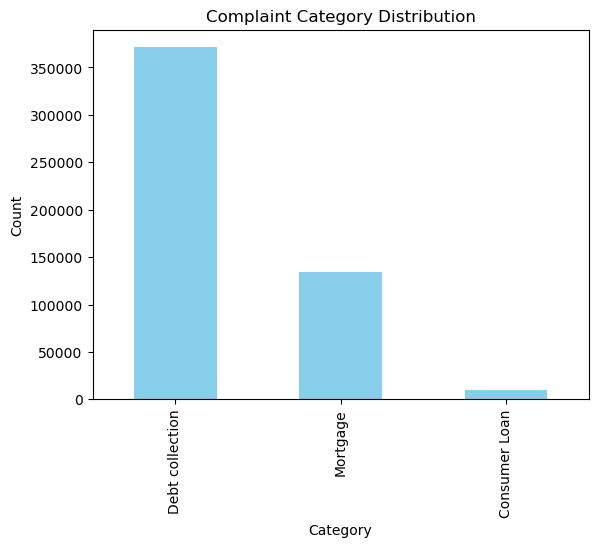

In [2]:
df = df[['Consumer complaint narrative', 'Product']].dropna()
df.rename(columns={'Consumer complaint narrative':'text','Product':'label'}, inplace=True)
category_map = {
    'Credit reporting, repair, or other': 0,
    'Debt collection': 1,
    'Consumer Loan': 2,
    'Mortgage': 3
}
df = df[df['label'].isin(category_map.keys())]
df['target'] = df['label'].map(category_map)
df['label'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Complaint Category Distribution')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()


In [3]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    words = [w for w in text.split() if w not in stop_words]
    return ' '.join(words)

df['clean_text'] = df['text'].apply(clean_text)
df.head()


[nltk_data] Downloading package stopwords to C:\Users\Ravi
[nltk_data]     D\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


,text,label,target,clean_text
204,RE : Attentively review my formal writ compose...,Debt collection,1,attentively review formal writ composed declar...
309,"This complaint is against S & S Recovery , Inc...",Debt collection,1,complaint recovery inc publishing unauthorized...
399,It stated that I owe a balance of {$720.00}. I...,Debt collection,1,stated owe balance paid full would receive xxx...
418,I hired XXXX XXXX XXXX to negotiate with my cr...,Debt collection,1,hired xxxx xxxx xxxx negotiate creditors resol...
439,SPS Select Portfolio Servicing of XXXX XXXX XX...,Debt collection,1,sps select portfolio servicing xxxx xxxx xxxx ...


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df['target'], 
                                                    test_size=0.2, random_state=42, stratify=df['target'])

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    
}

results = {}

for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")


Logistic Regression Accuracy: 0.9694
Naive Bayes Accuracy: 0.9460


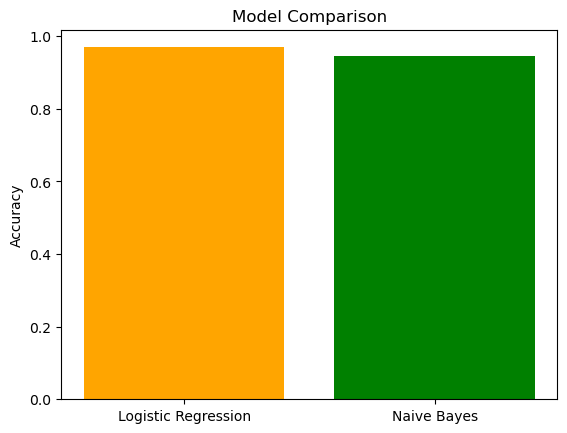

In [8]:
plt.bar(results.keys(), results.values(), color=['orange','green','blue'])
plt.title("Model Comparison")
plt.ylabel("Accuracy")
plt.show()


              precision    recall  f1-score   support

           1       0.98      0.98      0.98     74251
           2       0.77      0.49      0.60      1892
           3       0.96      0.96      0.96     26961

    accuracy                           0.97    103104
   macro avg       0.90      0.81      0.85    103104
weighted avg       0.97      0.97      0.97    103104



ValueError: The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of ticklabels (4).

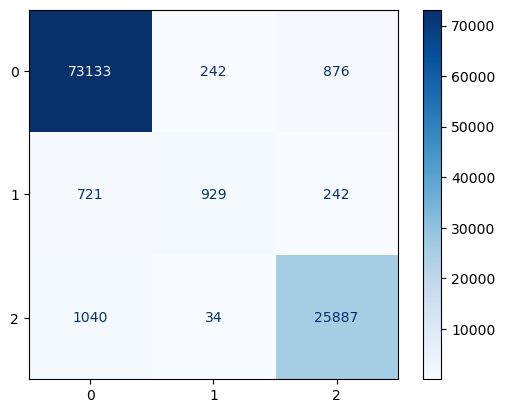

In [12]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

best_model = LogisticRegression(max_iter=1000)
best_model.fit(X_train_tfidf, y_train)
y_pred = best_model.predict(X_test_tfidf)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=category_map.keys())
disp.plot(cmap='Blues')
plt.show()


In [10]:
sample = ["My credit report shows wrong information and I need correction."]
sample_tfidf = vectorizer.transform(sample)
prediction = best_model.predict(sample_tfidf)[0]

for k,v in category_map.items():
    if v == prediction:
        print("Predicted Category:", k)


Predicted Category: Debt collection
